<a href="https://colab.research.google.com/github/Junseokee/Study-Python/blob/main/Dacon_%EC%88%98%ED%99%94_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이콘 수화데이터 분류

##환경 설정 및 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/dacon"
!unzip "user_data.zip"

In [2]:
import os
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

In [3]:
#하이퍼 파라미터 튜닝
CFG = {
  'IMG_SIZE':128, #이미지 사이즈
  'EPOCHS':50, #에포크
  'LEARNING_RATE':2e-2, #학습률
  'BATCH_SIZE':12, #배치사이즈
  'SEED':41 #시드
}

In [4]:
import random
import numpy as np

In [5]:
# random seed 고정
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [6]:
import pandas as pd
label_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/train.csv')
label_df.head() #라벨 확인

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


In [7]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


##데이터 전처리

In [8]:
#10-1 10-2라벨을 10 과 0으로 변경
label_df['label'][label_df['label'] == '10-1'] = 10 ##label : 10-1 -> 10
label_df['label'][label_df['label'] == '10-2'] = 0
label_df['label'] = label_df['label'].apply(lambda x : int(x)) ##Dtype : object -> int

In [9]:
label_df.head()

,file_name,label
0,001.png,0
1,002.png,10
2,003.png,3
3,004.png,8
4,005.png,9


In [10]:
label_df.info() #label이 object -> int64로 변경

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ KB


In [11]:
#데이터 이미지의 local adress와 label 값을 list에 저장
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    #print('wow', img_path_list)
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(label_df['label'])
    #print('wow2', label_list)
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    #print(img_path_list)
    
    return img_path_list

In [12]:
all_img_path, all_label = get_train_data('/content/drive/MyDrive/Colab Notebooks/dacon/train')
test_img_path = get_test_data('/content/drive/MyDrive/Colab Notebooks/dacon/test')

In [13]:
all_label[0:7]

[0, 10, 3, 8, 9, 9, 8]

##DataSet 구성

In [14]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

In [15]:
# Train : Validation = 0.75 : 0.25 Split
train_len = int(len(all_img_path)*0.75)
Vali_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [16]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', Vali_len)

train set 길이 :  643
vaildation set 길이 :  214


In [17]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #이미지 정규화
                    
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

##Dataloader
Dataloader class는 batch기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 합니다.

dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 됩니다.

만들었던 dataset을 input으로 넣어주면 여러 옵션(데이터 묶기, 섞기, 알아서 병렬처리)을 통해 batch를 만들어 내는 것입니다.

In [18]:
# Get Dataloader

#CustomDataset class를 통하여 train dataset생성
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 
#만든 train dataset를 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) #BATCH_SIZE : 24

#vaildation 에서도 적용
vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 643 / total train batches : 54
total valid imgs : 214 / total valid batches : 18


In [19]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 643 / total train batches : 54
total valid imgs : 214 / total valid batches : 18


##이미지 및 shape 확인
Dataloader를 통해서 이미지가 잘 넣어졌는지 확인해보도록 해보겠습니다

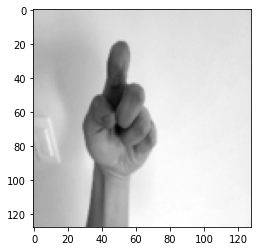

Label: 10


In [20]:
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)) #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features[0]
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

In [21]:
#torch의 shape가 올바르게 입력이 되었는지 확인
print(f"Feature batch shape: {train_features.size()}") #순서대로 size, channals, high, width
print(f"Batch Labels shape: {train_labels}") #배치 size에 맞게 출력 => 12개

Feature batch shape: torch.Size([12, 3, 128, 128])
Batch Labels shape: tensor([10,  2,  9,  7,  6,  2,  4,  7,  1,  8,  0,  9])


##모델 구조 정의
이제 CNN 모델을 학습시키기 위한 데이터가 준비되었다면
모델 구조를 설정하는 단계로 넘어가겠습니다.

In [23]:
from tqdm.auto import tqdm
import torch.nn as nn # 신경망들이 포함됨
import torch.nn.init as init # 텐서에 초기값을 줌

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(3136, 11) #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x) #1층
        
        x = self.layer2(x) #2층
         
        x = self.layer3(x) #3층
        
        x = self.layer4(x) #4층
        
        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열
        
        out = self.fc_layer(x)
        return out

###Convoultion Layer
Convolution Layer에서는 이미지의 특징(feature map)을 추출해내는 역할을 합니다.

입력 데이터가 주어지면 필터를 이용해 특징을 추출한 다음 아웃풋을 내보냅니다.

이 필터는 커널(Kernel) 혹은 가중치의 배열이라고도 부르며 이 값을 조정하는 것이 곧 학습을 의미합니다.

첫번째 Convolution Layer에서는 3x3 크기의 커널을 사용했습니다. 이는 곧 학습해야 할 가중치가 9개라는 뜻입니다.

###Stride
커널을 이동시키는 거리입니다. 특별한 언급이 없다면 1로 가정합니다.

Convolution을 하게되면 입력 데이터의 크기가 자연스럽게 줄어들게 되는데,

주변에 값이 0인 셀들을 추가(Padding)해서 입력 데이터의 크기를 유지시키기도 합니다.

###Padding
zero padding은 이미지 주위에 0을 둘러서 이미지 데이터의 축소를 방지해주는 역할을 합니다.

필터로 인해 특징이 추출되면 자연스럽게 크기가 작아지는데,

이미지 벡터들 가장자리에 0을 채워 Convolution Layer를 통과할 때 크기를 동일하게 유지시켜줄 수 있습니다.

###ReLU
앞서 도입부에서 말씀 드린 것 처럼, ReLU는 활성화 함수 중 하나입니다.

Gradient Vanishing 문제를 해결 가능하고 계산이 빠르고 양 극단값이 포화되지 않는다는 장점이 있습니다.

###Pooling Layer - Max Pooling
Pooling Layer는 데이터의 공간적 크기를 축소하는데 사용합니다.

보통 이 레이어에서 이미지의 크기를 조절하며, CNN에서는 주로 Max-Pooling 방식을 사용합니다.

Conv layer 는 이미지의 특정 영역의 특징을 잡아내는 역할이라면,

Pooling 은 이미지의 크기를 줄이는 동시에 이미지의 전체의 특징 또한 보존합니다.

따라서 Pooling 은 모델로 하여금 이미지 전체를 볼 수 있게 도와줍니다.

Max Pooling에서는 선택된 영역에서 가장 큰 값을 뽑아 대표값으로 설정하는 방식입니다.

이를 통해 학습 시간을 단축하고 오버피팅 문제를 완화할 수 있습니다.

###Fully Connected (output) Layer
이전 레이어의 출력을 평탄화하여 다음 스테이지의 입력이 될 수 있는 단일 벡터로 변환합니다.

마지막으로 각 라벨에 대한 최종 확률을 제공합니다.

##모델 학습
이제 모델 학습을 하기 위해 매개변수를 정의해보도록 하겠습니다.

In [25]:
#기본 CNN classification 모델을 사용
import torch.optim as optim # 최적화 알고리즘들이 포함힘

model = CNNclassification().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

###Loss Function
손실함수로는 classification 문제이기 때문에 'CrossEntropyLoss'를 사용했습니다.

손실함수는 실제 값과 모델이 예측한 값의 거리를 출력하는 함수 입니다.

쉽게 말해 손실함수는 모델의 예측이 얼마나 틀렸는지를 알려주는 함수 입니다.

이 때 "모델의 예측이 얼마나 틀렸는지" 를 어떻게 정의하느냐에 따라 어떤 Loss Function 을 사용할 지가 정해지는 것 입니다.

###Optimizer
최적화 함수로는 확률적 경사 하강법인 'SGD(Stochastic Gradient Descent)'를 사용했습니다.

Optimizer는 학습 데이터(Train data)셋을 이용하여 모델을 학습 할 때 데이터의 실제 결과와 모델이 예측한 결과를 기반으로 잘 줄일 수 있게 만들어주는 역할을 합니다.

여기서 learning rate, 학습률은 얼마나 빠른속도로 이동할것이냐 입니다.

learning rate를 엄청 크게 설정한다면 원하는 값까지 빠르게 도달할 수 있지만 자칫하면 오히려 최소값을 계산하도록 수렴하지 못합니다.

반면 너무 작은 경우는 시간이 매우 오래걸립니다.

따라서 적절한 learning rate설정이 중요합니다.


In [28]:
#train 메소드를 통해 train 학습시켜 평가(vaildation)
def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    
    #Loss Function 정의
    criterion = nn.CrossEntropyLoss().to(device)
    best_acc = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1): #에포크 설정
        model.train() #모델 학습
        running_loss = 0.0
            
        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device) #배치 데이터
            optimizer.zero_grad() #배치마다 optimizer 초기화
        
            # Data -> Model -> Output
            logit = model(img) #예측값 산출
            loss = criterion(logit, label) #손실함수 계산
            
            # 역전파
            loss.backward() #손실함수 기준 역전파 
            optimizer.step() #가중치 최적화
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        #Validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        vali_loss = 0.0
        correct = 0
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for img, label in tqdm(iter(vali_loader)):
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))
        
        #베스트 모델 저장
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/dacon/Untitled Folder/best_model.pth') #이 디렉토리에 best_model.pth을 저장
            print('Model Saved.')

##epoch
딥러닝에서 epoch는 전체 트레이닝 셋이 신경망을 통과한 횟수입니다.

1-epoch는 전체 트레이닝 셋이 하나의 신경망에 적용되어 순전파와 역전파를 통해 신경망을 한 번 통과했다는 뜻입니다.

epoch 은 많을 수록 학습이 잘되는 것이 아닙니다.

epoch 이 너무 적을 경우 학습이 덜 이루어지는 경우가 있고, epoch 이 너무 많을 경우 과적합이 되는 경우가 있습니다.

따라서 적절한 epoch 을 설정해 주어야 합니다.

이때 validation loss 와 accuracy 은 epoch 을 언제 중단 할지 모니터링 하는 용도로 사용되기도 합니다.

##batch size
batch size란 cpu 또는 gpu 연산 시, 하드웨어로 로드되는 데이터의 개수 입니다.

본인의 컴퓨팅 환경에 따라 batch size 를 조절하는 것이 좋습니다.

gpu 를 사용하는 경우 본인의 gpu 메모리 용량을 고려하여 batch size 를 설정해 주어야 합니다.

batch size 는 모델 학습 과정에 영향을 끼치기도 합니다.

따라서 하드웨어 상황을 고려하면서도 학습 과정 또한 고려하여 batch size 를 설정해 주어야 합니다.

##Backpropagation (역전파)
Backpropagation 오차 역전파법이라고도 하며 예측값과 실제값의 차이인 오차를 계산하고,

이것을 다시 역으로 전파하여 가중치를 수정하여 오차가 작아지는 방향으로 일정 횟수를 반복해 수정하는 방법입니다.

이때, 역전파 과정에서는 앞서 언급했던 최적화 함수를 이용합니다.

In [29]:
train(model, optimizer, train_loader, scheduler, device)

  0%|          | 0/54 [00:00<?, ?it/s]

[1] Train loss: 2.3941987709


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4013, Accuracy: 26/215 ( 12%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[2] Train loss: 2.3918988042


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4025, Accuracy: 23/215 ( 11%)



  0%|          | 0/54 [00:00<?, ?it/s]

[3] Train loss: 2.3891034612


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4021, Accuracy: 24/215 ( 11%)



  0%|          | 0/54 [00:00<?, ?it/s]

[4] Train loss: 2.3860271021


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4030, Accuracy: 28/215 ( 13%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[5] Train loss: 2.3802340296


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4001, Accuracy: 25/215 ( 12%)



  0%|          | 0/54 [00:00<?, ?it/s]

[6] Train loss: 2.3705436918


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3925, Accuracy: 29/215 ( 13%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[7] Train loss: 2.3560892741


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3726, Accuracy: 21/215 ( 10%)



  0%|          | 0/54 [00:00<?, ?it/s]

[8] Train loss: 2.3168950081


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3504, Accuracy: 36/215 ( 17%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[9] Train loss: 2.2605546536


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2882, Accuracy: 49/215 ( 23%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[10] Train loss: 2.1592984531


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2200, Accuracy: 43/215 ( 20%)



  0%|          | 0/54 [00:00<?, ?it/s]

[11] Train loss: 2.0116048146


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.0921, Accuracy: 62/215 ( 29%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[12] Train loss: 1.8069974913


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.0947, Accuracy: 57/215 ( 27%)



  0%|          | 0/54 [00:00<?, ?it/s]

[13] Train loss: 1.5481949360


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.7666, Accuracy: 88/215 ( 41%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[14] Train loss: 1.3102253400


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9540, Accuracy: 78/215 ( 36%)



  0%|          | 0/54 [00:00<?, ?it/s]

[15] Train loss: 1.0732231262


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9173, Accuracy: 91/215 ( 42%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[16] Train loss: 0.9060571580


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.5441, Accuracy: 115/215 ( 53%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[17] Train loss: 0.7018110178


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8706, Accuracy: 104/215 ( 48%)



  0%|          | 0/54 [00:00<?, ?it/s]

[18] Train loss: 0.6149416519


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.6808, Accuracy: 106/215 ( 49%)



  0%|          | 0/54 [00:00<?, ?it/s]

[19] Train loss: 0.5433078690


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8086, Accuracy: 119/215 ( 55%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[20] Train loss: 0.3996214878


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.0144, Accuracy: 112/215 ( 52%)



  0%|          | 0/54 [00:00<?, ?it/s]

[21] Train loss: 0.2746053560


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.0244, Accuracy: 122/215 ( 57%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[22] Train loss: 0.2721985371


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8909, Accuracy: 132/215 ( 61%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[23] Train loss: 0.1832089543


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.7232, Accuracy: 109/215 ( 51%)



  0%|          | 0/54 [00:00<?, ?it/s]

[24] Train loss: 0.1778789294


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4389, Accuracy: 123/215 ( 57%)



  0%|          | 0/54 [00:00<?, ?it/s]

[25] Train loss: 0.2093904527


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8761, Accuracy: 125/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[26] Train loss: 0.1033564191


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3215, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[27] Train loss: 0.1225812794


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1869, Accuracy: 129/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[28] Train loss: 0.0946684890


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2719, Accuracy: 128/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[29] Train loss: 0.1122385639


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1729, Accuracy: 137/215 ( 64%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[30] Train loss: 0.0657847084


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2698, Accuracy: 133/215 ( 62%)



  0%|          | 0/54 [00:00<?, ?it/s]

[31] Train loss: 0.0451560874


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4404, Accuracy: 131/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[32] Train loss: 0.0425177094


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3450, Accuracy: 129/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[33] Train loss: 0.0571593634


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2688, Accuracy: 136/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[34] Train loss: 0.0684960911


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3017, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[35] Train loss: 0.0371629307


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3454, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[36] Train loss: 0.0259402412


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3240, Accuracy: 134/215 ( 62%)



  0%|          | 0/54 [00:00<?, ?it/s]

[37] Train loss: 0.0178942063


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4930, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[38] Train loss: 0.0258248189


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5516, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[39] Train loss: 0.0220075215


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4752, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[40] Train loss: 0.0100580836


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.6269, Accuracy: 133/215 ( 62%)



  0%|          | 0/54 [00:00<?, ?it/s]

[41] Train loss: 0.0231736902


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.6138, Accuracy: 131/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[42] Train loss: 0.0040879050


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8368, Accuracy: 128/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[43] Train loss: 0.0026659788


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.9279, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[44] Train loss: 0.0014371442


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.0158, Accuracy: 129/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[45] Train loss: 0.0011958868


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.0897, Accuracy: 129/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[46] Train loss: 0.0010362242


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.1454, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[47] Train loss: 0.0008991184


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.1996, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[48] Train loss: 0.0008192804


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.2493, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[49] Train loss: 0.0007257024


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.2932, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[50] Train loss: 0.0006672889


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.3334, Accuracy: 130/215 ( 60%)



##추론하기
이제 학습된 best_model을 가지고 test 셋의 라벨을 추론해보도록 하겠습니다.

In [49]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [50]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/dacon/Untitled Folder/best_model.pth')
model = CNNclassification().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

  0%|          | 0/18 [00:00<?, ?it/s]

[1, 8, 1, 1, 9]

##제출하기
submission에 예측한 값 preds를 넣어줍시다

In [51]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/Untitled Folder/sample_submission.csv')
submission['label'] = preds

In [52]:
#라벨과 타입 복원
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
submission.head(20)

,file_name,label
0,001.png,1
1,002.png,8
2,003.png,1
3,004.png,1
4,005.png,9
5,006.png,10-1
6,007.png,4
7,008.png,2
8,009.png,4
9,010.png,4


In [54]:
submission.to_csv('submit.csv', index=False)